In [403]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import os
from os.path import join as oj
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.linear_model import LinearRegression, LogisticRegression, RidgeCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn import metrics
import eli5
import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from torch import nn
import torch.nn.functional as F
import torch
from copy import deepcopy
from sklearn import metrics
plt.style.use('dark_background')
import mat4py
import pandas as pd
import data_tracks
import models
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import KFold
from colorama import Fore
import pickle as pkl
from tqdm import tqdm
from style import *
from sklearn import decomposition
import matplotlib.gridspec as grd
import itertools
from sklearn import mixture
from matplotlib_venn import venn3, venn2
import viz
outcome_def = 'y_consec_thresh'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
df = data_tracks.get_data(use_processed=False, use_processed_dicts=True, 
                           outcome_def=outcome_def)
viz.print_metadata()

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	removing hotspots....
	adding features...
valid:		1862 aux+ / 7594 (0.245)
----------------------------------------
no_hotspots:	1662 aux+ / 7394 (0.225)
----------------------------------------
lifetime<=26:	4720 aux+ / 5127 (0.921)
lifetime>=236:	   3 aux- /    3 (1.000)
remaining:	1252 aux+ / 2264 (0.553)


# visualize outcomes
- take mean, take sigma, define events with a threshold

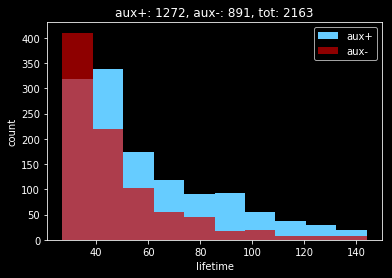

In [6]:
outcome = df[outcome_def]
aux_pos = df['lifetime'][outcome==1] 
aux_neg = df['lifetime'][outcome==0] 
plt.hist(aux_pos, label='aux+', alpha=1, color=cb)
plt.hist(aux_neg, label='aux-', alpha=0.7, color=cr)
plt.xlabel('lifetime')
plt.ylabel('count')
plt.title(f'aux+: {aux_pos.shape[0]}, aux-: {aux_neg.shape[0]}, tot: {df.shape[0]}')
plt.legend()
plt.show()

In [6]:
def sort_outcome(df, outcome_def):
    outcome_score = df['Y_max'].values
    idxs_sort = np.argsort(outcome_score)
    return df[outcome_def].values[idxs_sort], df['Y'].values[idxs_sort]

outcome_sort, Y_sort = sort_outcome(df, outcome_def)

## Find rule-based model to define aux+

In [252]:
verified_pids = data_tracks.get_labels()
df_label_verified = df[df.pid.isin(verified_pids['neg'] + verified_pids['pos'])]

In [157]:
def cummax(arr):
    res = [arr[0]]
    for i in range(1, len(arr)):
        res.append(max(arr[i], res[i-1]))
    return res
    
def max_fall(arr):
    cm = cummax(arr)
    return np.max(np.array(cm) - np.array(arr))
    
def max_diff(arr):
    return np.max(-np.diff(arr)) 

def max_absolute_fall(arr):
    cm_rev = cummax(arr[::-1])[::-1]
    return max(arr[i] - cm_rev[i+1] for i in range(len(arr)-1))

### Features

In [72]:
# peak time
df['Y_peak_time_frac'] = df['Y_peak_idx'].values / df['lifetime'].values
df['peak_time_frac_diff'] = df['Y_peak_time_frac']  - df['X_peak_time_frac'] 

In [387]:
# local
X_max_around_Y_peak = []
X_max_before_Y_peak = []
X_max_after_Y_peak = []
X_max_fall_around_Y_peak = []  # max fall def: in a window around aux peak, max_{t_1>t_2} Cla(t_1) - Cla(t_2)
X_max_diff_around_Y_peak = []  # max_{t in window} Cla(t) - Cla(t-1)
X_max_abs_fall_around_Y_peak = [] 
for i in range(len(df)):
    pt = df['Y_peak_idx'].values[i]
    lt = df['lifetime'].values[i]
    left_bf = np.int(0.2 * lt)
    right_bf = np.int(0.2 * lt)
    arr_before = df['X'].iloc[i][: max(1, pt - left_bf)]
    arr_around = df['X'].iloc[i][max(0, pt - left_bf): min(pt + right_bf, lt)]
    arr_after = df['X'].iloc[i][min(pt + right_bf, lt - 1): ]
    X_max_fall_around_Y_peak.append(max_fall(arr_around))
    X_max_diff_around_Y_peak.append(max_diff(arr_around))
    X_max_before_Y_peak.append(max(arr_before))
    X_max_around_Y_peak.append(max(arr_around))
    X_max_after_Y_peak.append(max(arr_after))
    X_max_abs_fall_around_Y_peak.append(max_absolute_fall(arr))
    
df['X_max_fall_around_Y_peak'] = X_max_fall_around_Y_peak
df['X_max_abs_fall_around_Y_peak'] = X_max_abs_fall_around_Y_peak
df['X_max_diff_around_Y_peak'] = X_max_diff_around_Y_peak
df['X_max_around_Y_peak'] = X_max_around_Y_peak
df['X_max_before_Y_peak'] = X_max_before_Y_peak
df['X_max_after_Y_peak'] = X_max_after_Y_peak
df['X_max_diff_around_before'] = df['X_max_around_Y_peak'] - df['X_max_before_Y_peak']
df['X_max_diff_around_after'] = df['X_max_around_Y_peak'] - df['X_max_after_Y_peak']

In [414]:
Y_feat_names = ['y_consec_sig', 
                'y_conservative_thresh', 
                'Y_peak_time_frac', 
                'Y_max',
                #'peak_time_frac_diff',
                #'y_num_sig',
                'X_max_fall_around_Y_peak',
                #'X_max_diff_around_Y_peak',
                #'X_max_abs_fall_around_Y_peak',
                'X_max_diff_around_after', 
                #'X_max_diff_around_before'
               ]

In [ ]:
## Accuracy of rule-bas

In [420]:
outcome_def = 'y_consec_thresh'
X = df_label_verified[Y_feat_names]
y = df_label_verified[outcome_def].values
    
m = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
num_pts_by_fold_cv = []
cv_accuracy = []

cell_nums_train = np.array([1, 2, 3, 4, 5])
kf = KFold(n_splits=len(cell_nums_train))

for cv_idx, cv_val_idx in kf.split(cell_nums_train):
    
    idxs_test = df_label_verified.cell_num.isin(cell_nums_train[np.array(cv_val_idx)])
    idxs_train = df_label_verified.cell_num.isin(cell_nums_train[np.array(cv_idx)])
    X_test, Y_test = X[idxs_test], y[idxs_test]
    X_train, Y_train = X[idxs_train], y[idxs_train]
    num_pts_by_fold_cv.append(len(X_test))
    m.fit(X_train, Y_train)
    cv_accuracy.append(m.score(X_test, Y_test))
    
np.average(cv_accuracy, weights=num_pts_by_fold_cv)

0.884469696969697

In [401]:
print(cv_accuracy)

[0.8448275862068966, 0.8795180722891566, 0.8059701492537313, 0.9492753623188406, 0.8951612903225806]


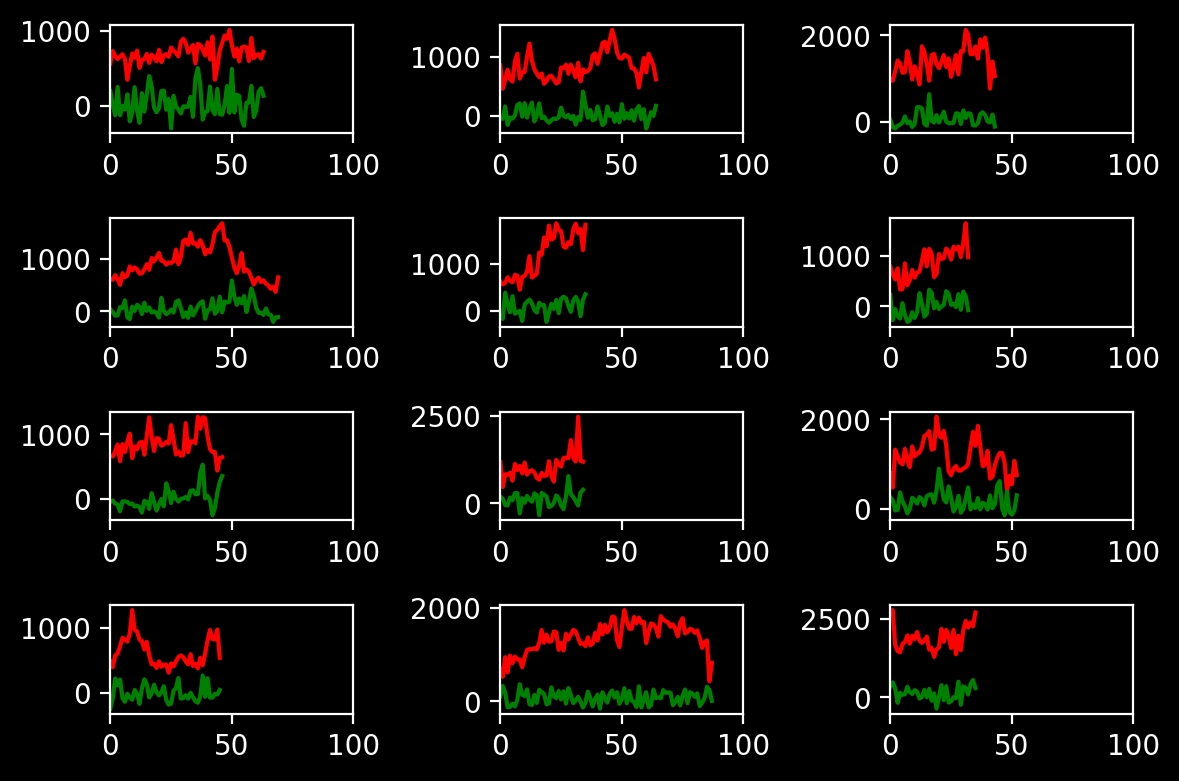

In [384]:
R, C = 4, 3
plt.figure(figsize=(6, 4), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    n1 = np.where(df['y_consec_thresh'] == 0)[0][i]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df.iloc[n1].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

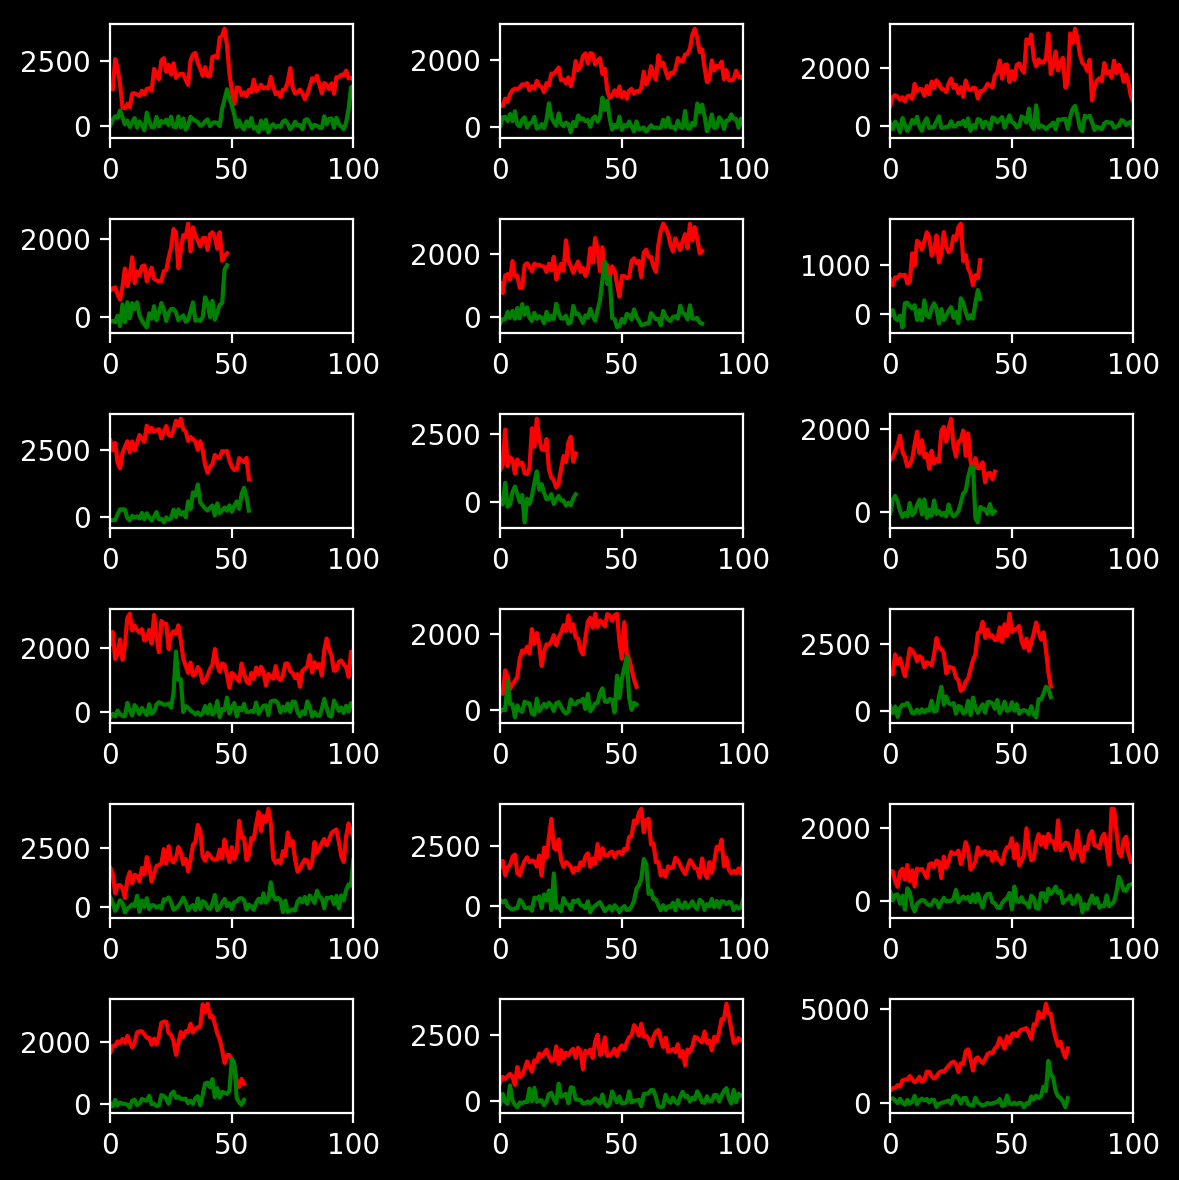

In [385]:
R, C = 6, 3
plt.figure(figsize=(6, 6), dpi=200)
lifetime_max = np.max(df.lifetime.values[:R*C])
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    row = df.iloc[i]
    n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    #n1 = np.where(df['y_consec_thresh'] == 1)[0][i]
    plt.plot(df.iloc[n1].X, color='red', label='clathrin')
    plt.plot(df.iloc[n1].Y, color='green', label='auxilin')
    plt.xlim((0, 100))
    #if not i == R * C - C:
    #plt.yticks([])
    #plt.xticks([])
#plt.legend()
plt.tight_layout()
plt.show()

# viz curves

In [ ]:
viz.plot_curves(df[df.pid.isin(data_tracks.get_labels()['hotspots'])])

In [ ]:
R, C = 4, 5
# plt.figure(dpi=200)
plt.figure(figsize=(9, 8), dpi=200)
n = Y_sort.shape[0]
# idxs = list(range(10)) + list(range(n - 10, n)) # let's look at the top / bot
idxs = list(range(num_neg - 40, num_neg + 40)) # let's look at ones in the middle
for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Y_sort[idx], color=cr if outcome_sort[idx] == 0 else cb)
#     plt.axis('off')
plt.tight_layout()

**compare as a func of aux_max**

In [ ]:
R, C = 20, 28
# plt.figure(dpi=200)
plt.figure(figsize=(28, 20))
n = Y_sort.shape[0] # 1434

idxs = np.array([np.arange(int(i), int(i) + C) for i in np.linspace(0, n - C, R)]).flatten() #list(range(10)) + list(range(n - 10, n))
Ys = Y_sort[idxs]
ymin = -200
ymax = 4000

for i in range(R * C):
    plt.subplot(R, C, i + 1)
    idx = idxs[i]
    plt.plot(Ys[i], color=cr if outcome_sort[idx] == 0 else cb, lw=1)
    plt.ylim((ymin - 1, ymax + 1))
    plt.xlim((0, 120))
    if not i == R * C - C:
        plt.yticks([])
        plt.xticks([])
    if i % C == 0:
        plt.ylabel(f'{np.max(Ys[i]):.0f}')
#     plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(hspace=0, wspace=0)
plt.savefig('def.pdf')

In [ ]:
aux_plus = df[outcome_def] == 1
plt.hist(df[aux_plus]['Y_max'], color=cb, label='aux+', bins=100)
plt.hist(df[~aux_plus]['Y_max'], color=cr, label='aux-', alpha=0.7, bins=100)
plt.xlabel('aux_max')
plt.ylabel('count')
plt.legend()
plt.show()

**look at hotspots**

In [16]:
dfh = data_tracks.get_data(use_processed=True, remove_hotspots=False,
                         processed_file='processed/df_with_hotspots.pkl', metadata_file='processed/metadata_with_hotspots.pkl',)

loading + preprocessing data...
	loading tracks...
	preprocessing data...
	adding features...
dict features not added!


In [ ]:
dh = dfh[df.hotspots==1]
R = int(np.sqrt(dh.shape[0]))
C = (dh.shape[0] // R) + 1
plt.figure(figsize=(C, R), dpi=200)

for i in range(R * C):
    if i < dh.shape[0]:
        ax = plt.subplot(R, C, i + 1)
        row = dh.iloc[i]
        plt.axis('off')
        Y = np.array(row['Y'])
        ts = np.arange(Y.size)
        plt.plot(ts, np.array(row['X']), color=cr, lw=1)
        plt.plot(ts, Y, color='green', lw=1)
        plt.plot(ts[row['sig_idxs']==True], Y[row['sig_idxs']], 'o', color='white', ms=1, alpha=0.5)

    #     plt.plot(dh.iloc[i]['X'], color='red')
        ax.text(.5, .9, f'{i}',
                         horizontalalignment='right',
                         transform=ax.transAxes)


        plt.ylim((-1000, 4000))
        plt.xlim((0, 120))

# plt.suptitle(f'clath divided by 2 to fit on same scale xscale is 120')
plt.tight_layout()
plt.savefig('hotspots.pdf')
plt.show()

# compare different outcome defs

In [ ]:
keys = ['y_thresh', 'y_single_sig', 'y_double_sig', 'y_consec_sig', 'y']
mat = df[keys] #.corr()# make fig
# plt.figure(dpi=200)
# sns.heatmap(mat.corr(method='spearman'), annot=True,
#             cmap=sns.diverging_palette(10, 240, as_cmap=True, center='light'), vmin=-1, vmax=1)
# plt.show()

plt.figure(dpi=200)
sns.barplot(x=keys, y=mat.sum(), color=cb, alpha=1)
plt.ylabel('num aux+')
plt.xlabel('aux+ definition')

In [ ]:
plt.figure(dpi=200)
idxs = np.arange(df.shape[0])
keys = ['y_thresh', 'y_single_sig', 'y_consec_sig']
venn3([set(idxs[df[keys[0]] == 1]), set(idxs[df[keys[1]] == 1]), set(idxs[df[keys[2]] == 1])], keys)
plt.show()

# analyze aux+ p-value / amplitude defs

In [4]:
aux = df.Y
aux_p = df.Y_pvals

ys = np.array(list(itertools.chain.from_iterable(aux)))
ps = np.array(list(itertools.chain.from_iterable(aux_p.values)))

ps_sig = ps < 0.05

In [ ]:
R = 1
C = 2
plt.figure(figsize=(8, 4), dpi=200)
plt.subplot(R, C, 1)
plt.hist(ps, bins=100, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
plt.yscale('log')
plt.axvline(0.05, color=cr)
plt.xlabel('auxilin p-value')
plt.ylabel('count (log-scale)')
# plt.xscale('log')
# plt.ylabel()
# plt.xlim((0, 0.1))
print(f'num sig {np.sum(ps_sig):,d}')
print(f'num nonsig {np.sum(~ps_sig):,d}')

plt.subplot(R, C, 2)
ys_sig = ys[ps_sig]
(counts, bins, _) = plt.hist(ys_sig, bins=180, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
idx_max = np.argmax(counts)
aux_max = bins[idx_max]
plt.axvline(aux_max, color=cr)
plt.xlabel('auxilin amplitude')
plt.ylabel('count')
plt.tight_layout()
plt.show()

print('aux_max', aux_max)

In [ ]:
ys_sig = ys_sig.reshape(-1, 1)
mog = mixture.GaussianMixture(n_components=3)
mog.fit(ys_sig.reshape(-1, 1))
preds = mog.predict(ys_sig.reshape(-1, 1))

# plot hist
plt.figure(dpi=200)
plt.hist(ys_sig, bins=bins, alpha=1, color=cb) #ps[(ps < 0.5) * (ps > 0.01)])
samples, comps = mog.sample(n_samples=ys_sig.size) 
for i in [0, 2, 1]:
    idxs = comps==i
    plt.hist(samples[idxs], bins=bins, alpha=0.75, label=f'{mog.means_[i, 0]}')
plt.axvline(aux_max, color='white')
# plt.legend()

plt.xlabel('auxilin amplitude (significant only)')
plt.ylabel('count')
plt.show()